In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import seaborn as sns

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Check prediction

In [24]:
class Predictor:

    def __init__(self, city, model_name, attr) -> None:
        self.model_name = model_name
        self.attr = attr
        self.model = self.get_model(city, model_name, attr)
    
    def get_model(self, city, model_name, attr):
        model = None
        if model_name == 'ARIMA':
            model = ARIMAForecast(city, attr)
        return model
    
    def train(self, data):
        self.model.train(data)
    
    def predict(self, street, data, timestep):
        used_data = data.copy()
        used_data.index = pd.DatetimeIndex(used_data['time'], freq='H')
        used_data = used_data.drop(columns=['time'])
        pred_res = self.model.predict(street=street, data=used_data, timestep=timestep)
        return pred_res

class ARIMAForecast:

    param_path = "../model/time_series/ARIMA_{}_{}.parquet.gzip"

    def __init__(self, city, attr):
        try:
            self.city = city
            self.attr = attr
            self.param = pd.read_parquet(self.param_path.format(city, attr))
        except:
            print("ARIMA model must be trained first")
    
    def train(self, data):
        lst_street = set(data['street'])

        result = []
        
        for street in lst_street:
            print("Train on {}".format(street))
            used_data = data[data['street'] == street].loc[:,['time', self.attr]]
            used_data.index = pd.DatetimeIndex(used_data['time'], freq='H')
            used_data = used_data.drop(columns=['time'])
            arima_model = auto_arima(
                used_data, start_p=1, d=0, start_q=1, test='adf',
                max_p=6, max_d=5, max_q=6, m=1, seasonal=False,
                start_P=0, D=0, trace=False, error_action='ignore',
                suppress_warnings=False, stepwise=True
            )
            p, d, q = arima_model.get_params().get("order")
            result.append([
                street,
                p,
                d,
                q
            ])
        
        result_df = pd.DataFrame(data=result, columns=['street', 'p', 'd', 'q'])
        result_df.to_parquet(
            self.param_path.format(self.city, self.attr),
            index=False,
            compression="gzip"
        )

    def predict(self, street, data, timestep):
        p, d, q = self.get_param(street)
        model = ARIMA(data.values, order=(p,d,q))
        model_fitted = model.fit()
        res = model_fitted.forecast(steps=timestep)
        return res

    def get_param(self, street):
        data = self.param[self.param['street'] == street]
        return data['p'].values[0], data['d'].values[0], data['q'].values[0]

In [19]:
dataset = pd.read_parquet("../data/processed/final_dataset_Bogor.parquet.gzip")

train_dataset = dataset[dataset['time_series_split'] == 'train']
test_dataset = dataset[dataset['time_series_split'] == 'test']

lst_street = list(set(train_dataset['street']))

In [25]:
model = Predictor(
    city='Bogor',
    model_name='ARIMA',
    attr='median_speed_kmh'
)

In [21]:
street = 'Surya Kencana'

used_train_data = train_dataset[train_dataset['street'] == street]
used_test_data = test_dataset[test_dataset['street'] == street]

In [26]:
pred_res = model.predict(
    street=street,
    data=used_train_data.loc[:,['time', 'median_speed_kmh']],
    timestep=used_test_data.shape[0]
)
pred_res.shape[0]

d:\DSLS\Mini Project\Data Scientist\.venv\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


286

# Error Analysis

In [3]:
lst_file = os.listdir("../data/eval_result/time_series")
lst_file

['ARIMA_Bogor_median_delay_overall.csv',
 'ARIMA_Bogor_median_delay_seconds_overall.csv',
 'ARIMA_Bogor_median_delay_seconds_street.csv',
 'ARIMA_Bogor_median_delay_seconds_time.csv',
 'ARIMA_Bogor_median_delay_street.csv',
 'ARIMA_Bogor_median_delay_time.csv',
 'ARIMA_Bogor_median_length_overall.csv',
 'ARIMA_Bogor_median_length_street.csv',
 'ARIMA_Bogor_median_length_time.csv',
 'ARIMA_Bogor_median_regular_speed_overall.csv',
 'ARIMA_Bogor_median_regular_speed_street.csv',
 'ARIMA_Bogor_median_regular_speed_time.csv',
 'ARIMA_Bogor_median_speed_kmh_overall.csv',
 'ARIMA_Bogor_median_speed_kmh_street.csv',
 'ARIMA_Bogor_median_speed_kmh_time.csv']

In [51]:
def extract_feature(filename):
    split = filename.split("_")
    used_data = [split[i] for i in range(2,len(split)-1)]
    return "_".join(used_data)

def get_overall_df(model_name, city):
    lst_file = os.listdir("../data/eval_result/time_series")
    template_path = "../data/eval_result/time_series/{}"
    related_file = [filename for filename in lst_file if 'overall' in filename and model_name in filename and city in filename]
    data = []
    for filename in related_file:
        feature_name = extract_feature(filename)
        tmp = pd.read_csv(template_path.format(filename))
        data.append([
            feature_name,
            tmp.iloc[0,1],
            tmp.iloc[0,2]
        ])
    result = pd.DataFrame(data=data, columns=['feature', 'rmse', 'mae'])
    return result

In [52]:
get_overall_df("ARIMA", "Bogor")

,feature,rmse,mae
0,median_delay,100.823259,58.859931
1,median_delay_seconds,16.855420,5.136940
2,median_length,479.631479,369.180811
3,median_regular_speed,0.690851,0.435304
4,median_speed_kmh,8.366097,6.729041


ARIMA Model performance on 'median_length' feature has to considered due the value is being highest among all of the other features

## Visualize Histogram

In [34]:
def visualize_hist(model, city, feature, group, metric):
    data = pd.read_csv(
        "../data/eval_result/time_series/{}_{}_{}_{}.csv".format(model, city, feature, group)
    )
    used_data = data[metric]
    plt.figure(figsize=(8,8))
    sns.histplot(used_data, kde=True)
    plt.show()

In [53]:
def visualize_hist(model, city, metric):
    lst_file = os.listdir("../data/eval_result/time_series")
    template_path = "../data/eval_result/time_series/{}"

    lst_group = ['street', 'time']
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))

    for i in range(len(lst_group)):
        group = lst_group[i]
        related_file = [filename for filename in lst_file if group in filename and model in filename and city in filename]
        for j in range(len(related_file)):
            filename = related_file[j]
            feature_name = extract_feature(filename)
            tmp = pd.read_csv(template_path.format(filename))
            sns.histplot(tmp[metric], ax=axs[i][j], kde=True).set_title('{}-{}'.format(group, feature_name))

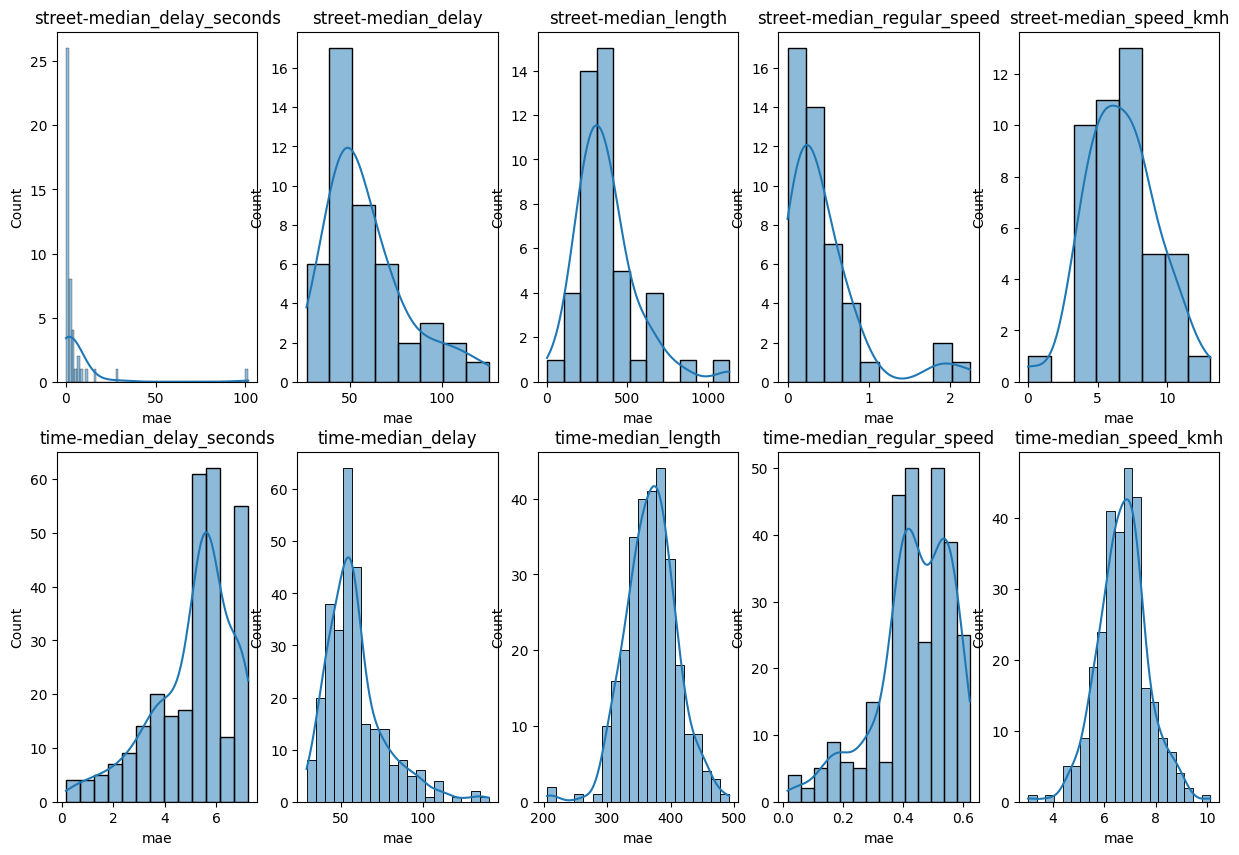

In [54]:
visualize_hist('ARIMA', 'Bogor', 'mae')

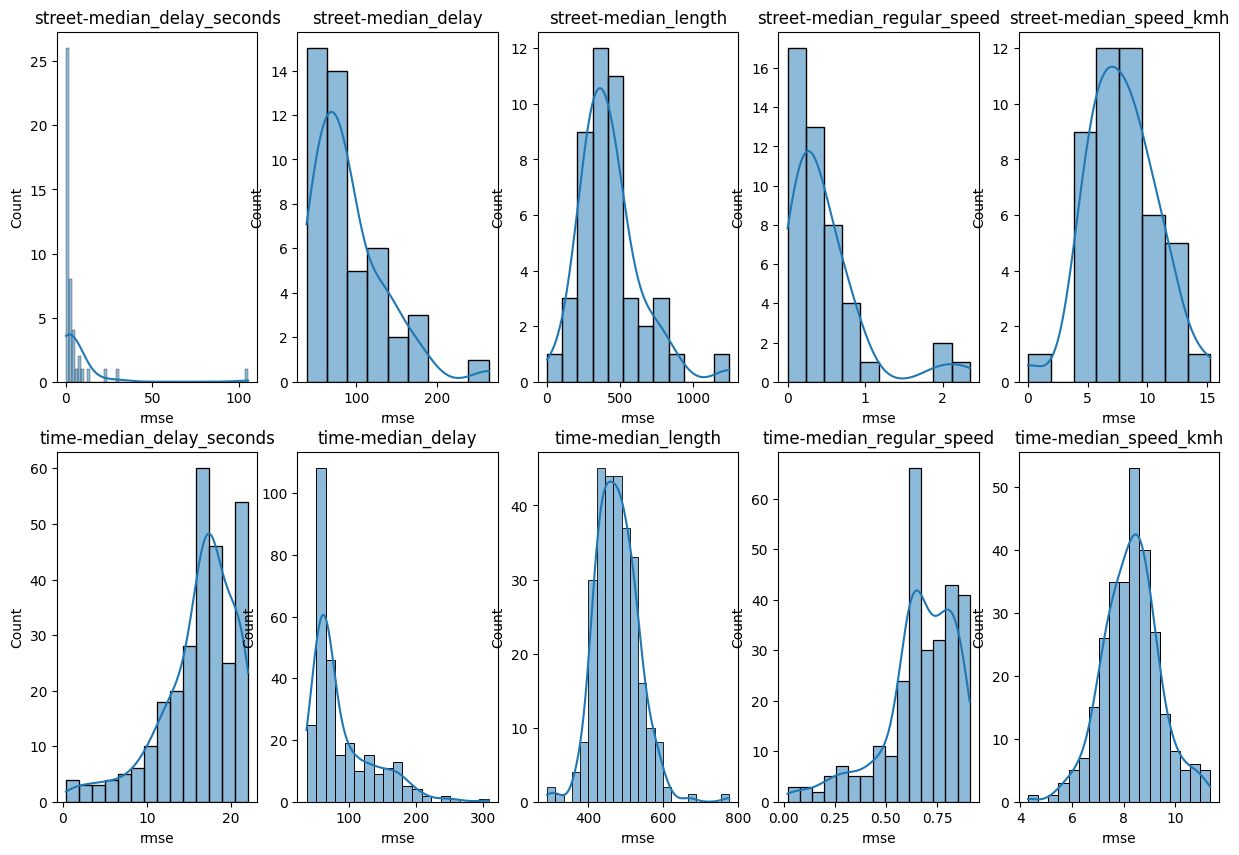

In [55]:
visualize_hist('ARIMA', 'Bogor', 'rmse')

## Visualize Lineplot

In [62]:
def visualize_lineplot(model, city, metric):
    lst_file = os.listdir("../data/eval_result/time_series")
    template_path = "../data/eval_result/time_series/{}"

    fig, axs = plt.subplots(5, 1, figsize=(15, 25))

    related_file = [filename for filename in lst_file if 'time' in filename and model in filename and city in filename]
    for i in range(len(related_file)):
        filename = related_file[i]
        feature_name = extract_feature(filename)
        tmp = pd.read_csv(template_path.format(filename))
        sns.lineplot(x='time', y=metric, data=tmp, ax=axs[i]).set_title(feature_name)

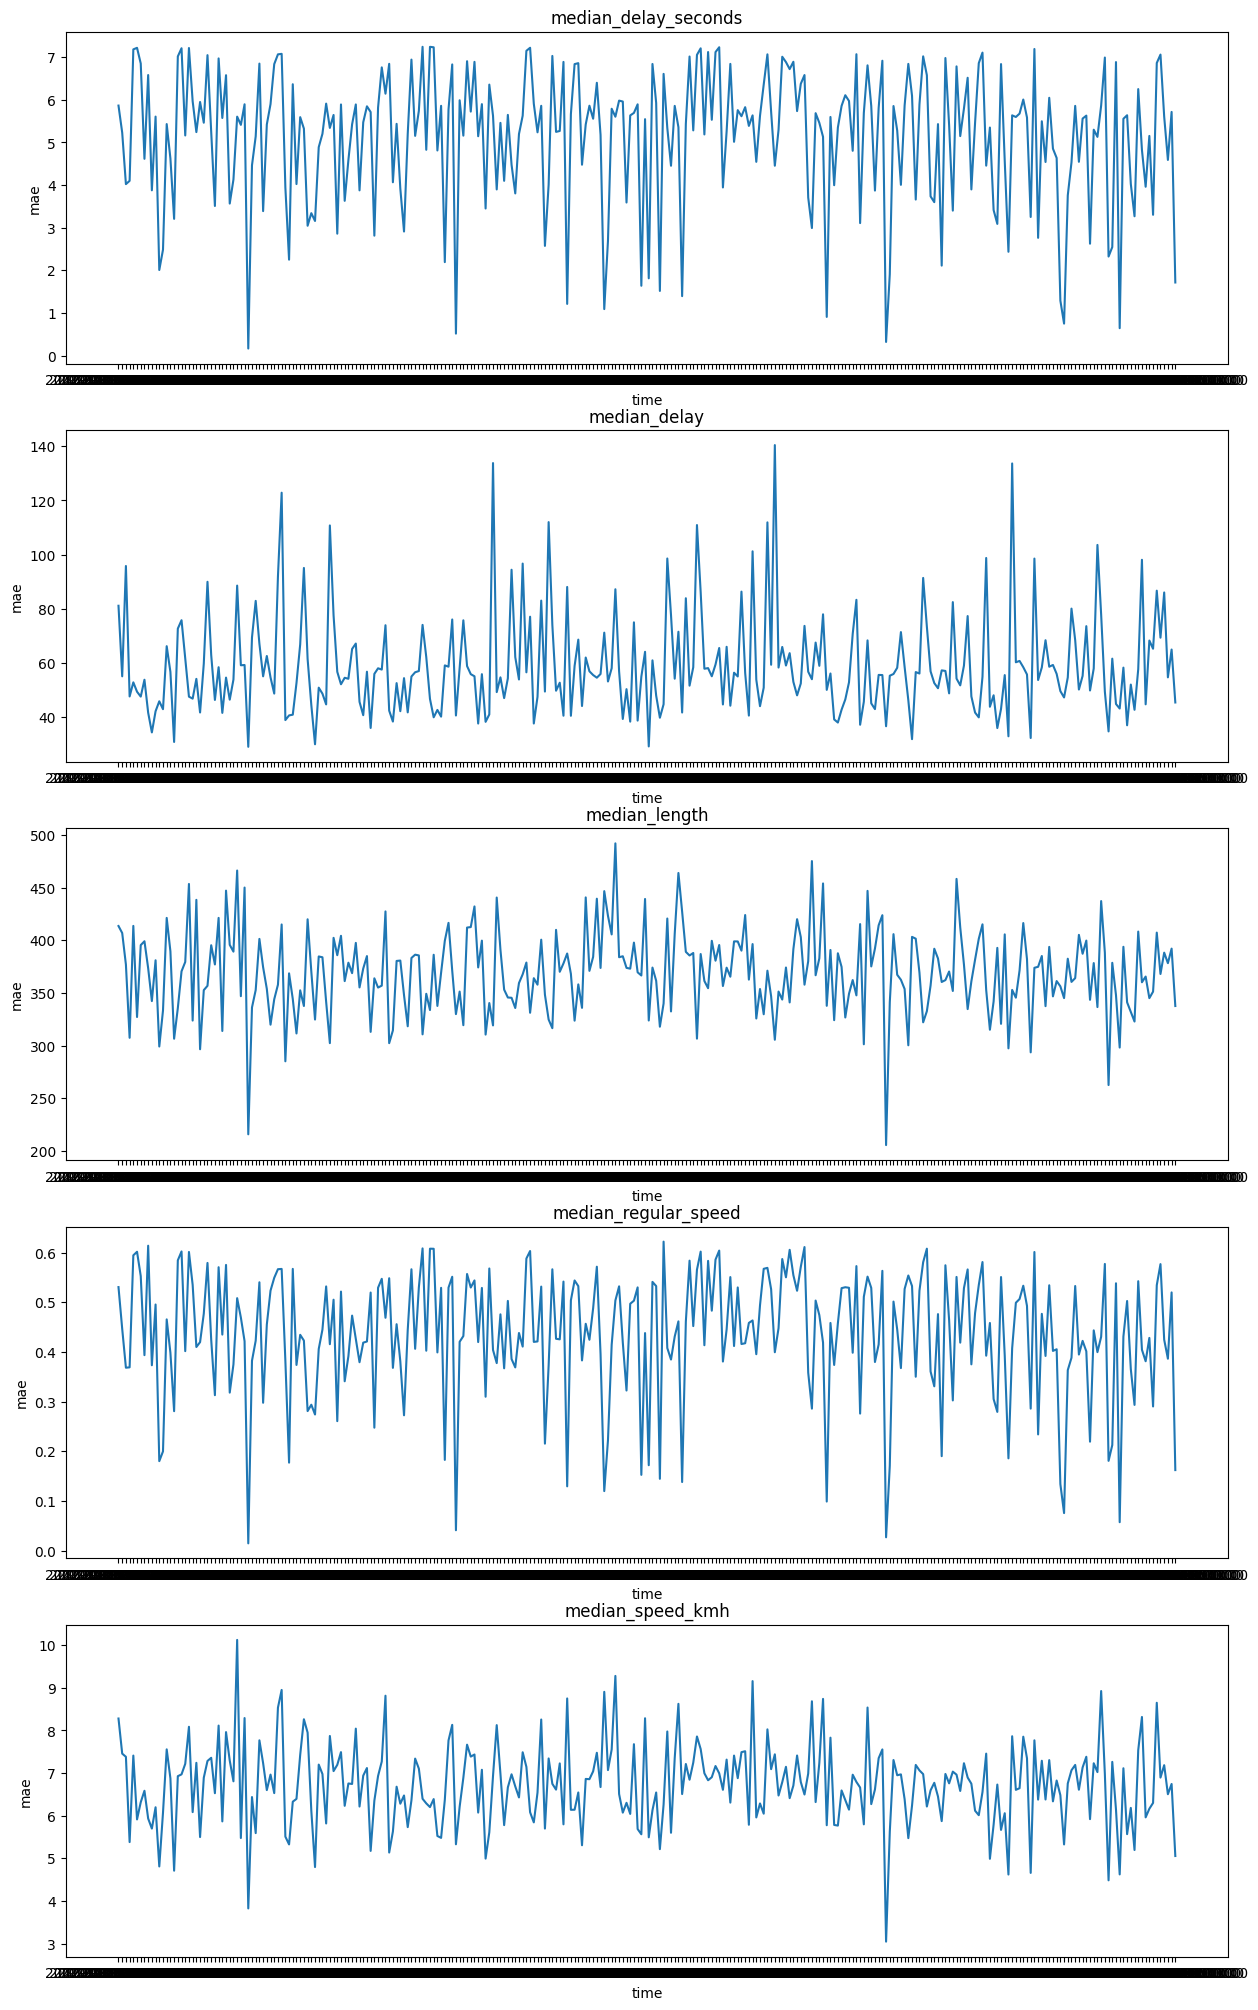

In [63]:
visualize_lineplot('ARIMA', 'Bogor', 'mae')

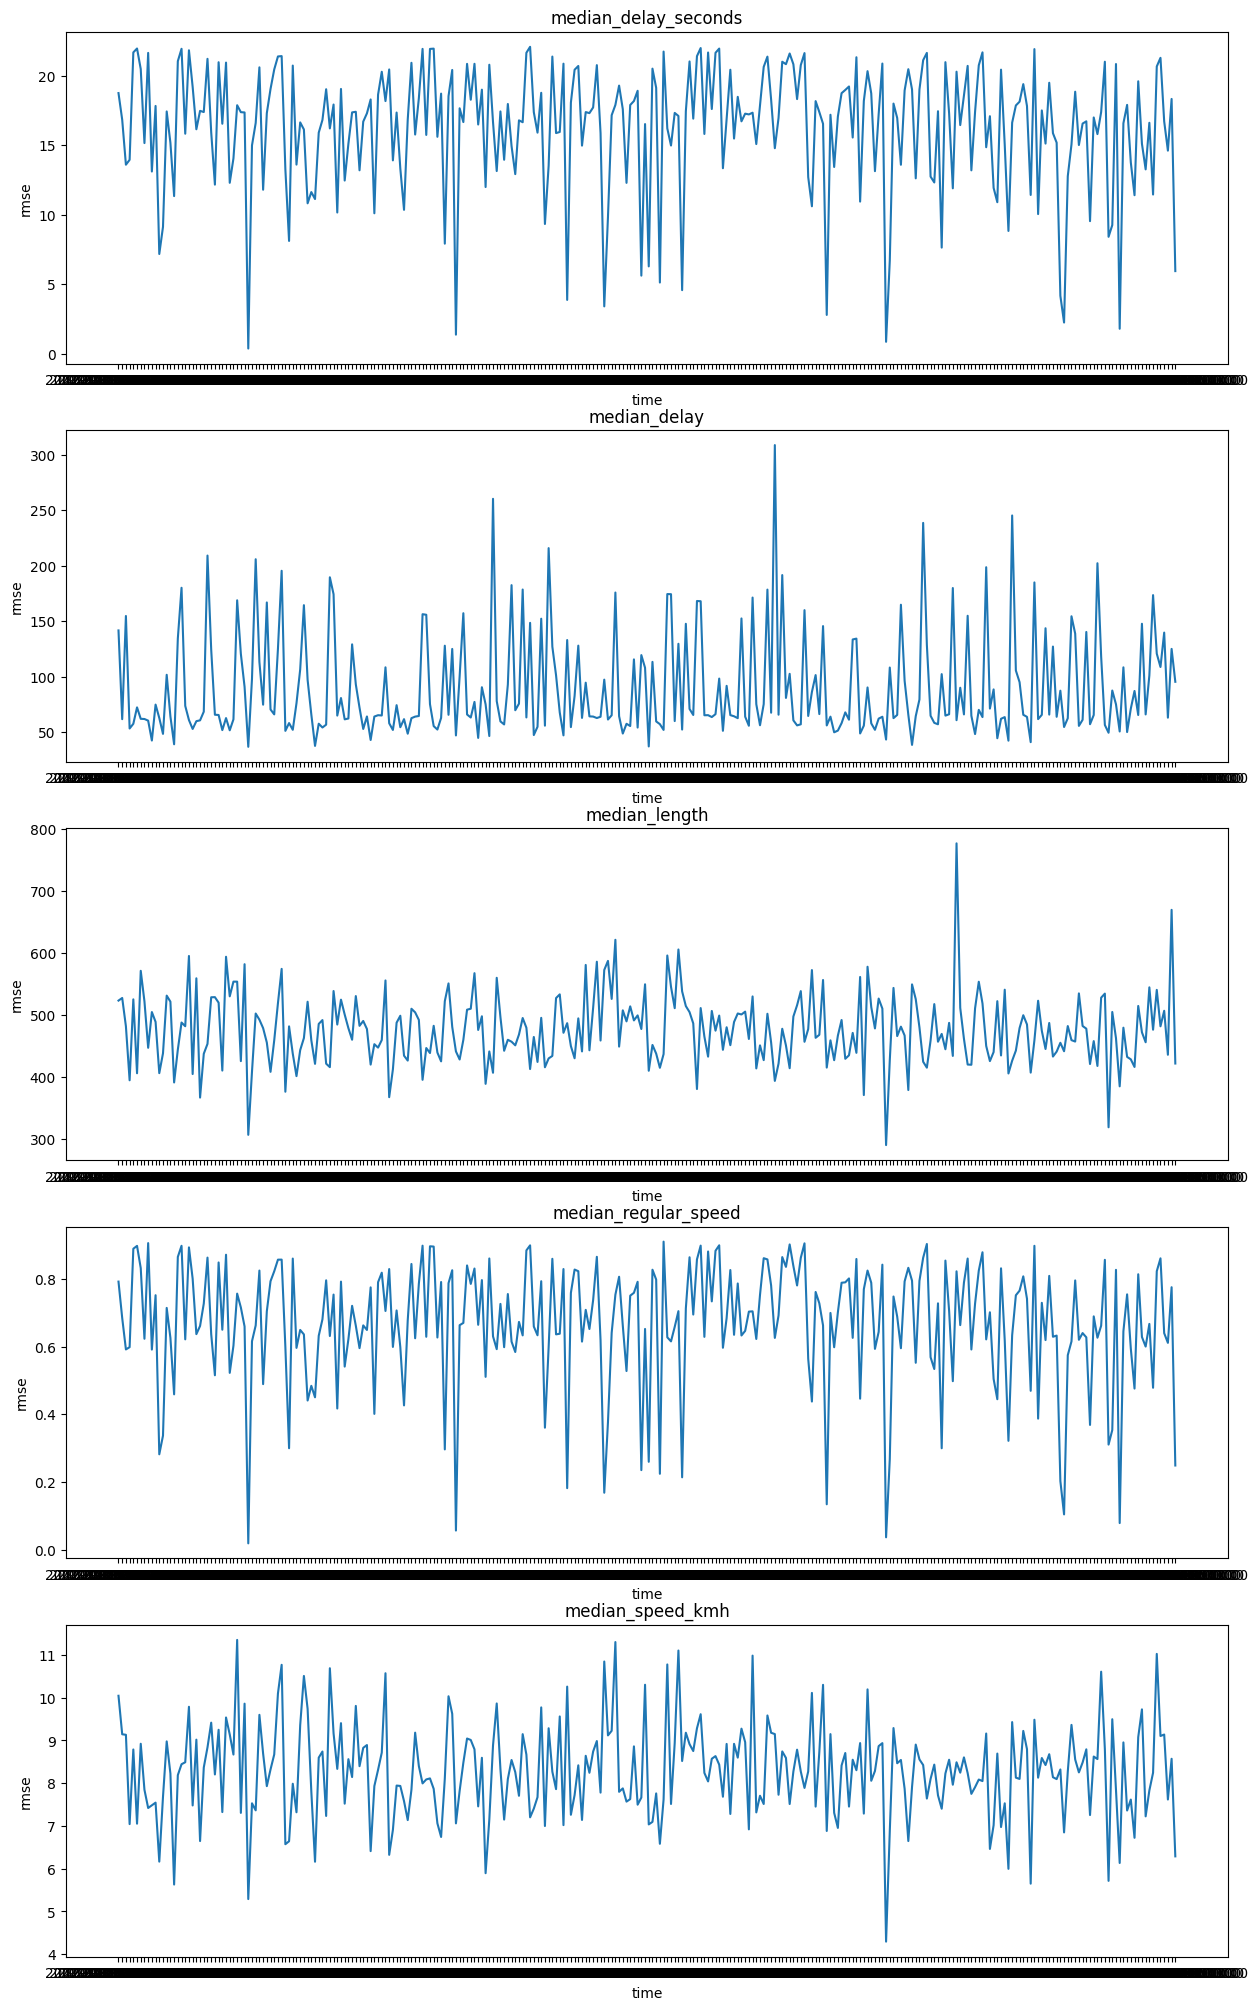

In [64]:
visualize_lineplot('ARIMA', 'Bogor', 'rmse')

- For all features, the existing prediction error isn't a exploding error type of error. It is because the error graph doesn't show any trend
- At the histogram, several features has different distribution at time and street aspect
  - Conclusion: The prediction result wasn't being precise on the time aspect, there were several features that has big value of error. But for the majority streets, they have several cases that made the prediction being precise, and it made the overall prediction result went lower

## Comparison

In [78]:
def get_comparison(model, city, feature, metric):
    df_eval_res = pd.read_csv(
        '../data/eval_result/time_series/{}_{}_{}_overall.csv'.format(model, city, feature)
    )
    df_ground_truth = pd.read_parquet(
        '../data/model_result/time_series/{}_{}_{}.parquet.gzip'.format(model, city, feature)
    )
    metric_value = df_eval_res.iloc[0,:][metric]
    return pd.DataFrame(
        data=[[
            feature,
            metric_value > np.min(df_ground_truth['actual']),
            metric_value > np.mean(df_ground_truth['actual']),
            metric_value > np.quantile(df_ground_truth['actual'],q=0.25),
            metric_value > np.quantile(df_ground_truth['actual'],q=0.5),
            metric_value > np.quantile(df_ground_truth['actual'],q=0.75),
            metric_value > np.max(df_ground_truth['actual']),
        ]],
        columns=['feature', 'min', 'mean', 'q25', 'q50', 'q75', 'max']
    )



In [79]:
model = 'ARIMA'
city = 'Bogor'
lst_feature = [
    'median_length', 
    'median_delay', 
    'median_speed_kmh', 
    'median_regular_speed', 
    'median_delay_seconds'
]

result = pd.DataFrame(columns=['feature', 'min', 'mean', 'q25', 'q50', 'q75', 'max'])

for feature in lst_feature:
    result = result.append(
        get_comparison(model, city, feature, 'mae'),
        ignore_index=True
    )

result


C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4191857553.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4191857553.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4191857553.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4191857553.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gib

,feature,min,mean,q25,q50,q75,max
0,median_length,True,False,False,False,False,False
1,median_delay,True,False,True,False,False,False
2,median_speed_kmh,True,False,False,False,False,False
3,median_regular_speed,True,False,False,False,False,False
4,median_delay_seconds,False,False,False,False,False,False


At the above are the comparasion between MAE metric value and the distribution on each feature

In [80]:
model = 'ARIMA'
city = 'Bogor'
lst_feature = [
    'median_length', 
    'median_delay', 
    'median_speed_kmh', 
    'median_regular_speed', 
    'median_delay_seconds'
]

result = pd.DataFrame(columns=['feature', 'min', 'mean', 'q25', 'q50', 'q75', 'max'])

for feature in lst_feature:
    result = result.append(
        get_comparison(model, city, feature, 'rmse'),
        ignore_index=True
    )

result

C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4226230619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4226230619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4226230619.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  result = result.append(
C:\Users\Gibran Brahmanta\AppData\Local\Temp\ipykernel_2628\4226230619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(
C:\Users\Gib

,feature,min,mean,q25,q50,q75,max
0,median_length,True,False,False,False,False,False
1,median_delay,True,True,True,True,False,False
2,median_speed_kmh,True,False,False,False,False,False
3,median_regular_speed,True,False,False,False,False,False
4,median_delay_seconds,True,False,True,False,False,False


At the above are the comparasion between RMSE metric value and the distribution on each feature

- From those two tables, we can conclude that the error that are being happened in the prediction can still considered safe because all of the metric value is less than the mean value of each feature